# CAB420, DCNNs, Additional Example 4: Training Parameters

Dr Simon Denman (s.denman@qut.edu.au)

## Overview

There are a lot of options to set when training networks, let's look at some.

## Too Long; Didn't Read:

The main take home messages from this example are:
* If in doubt, use the defaults. They work pretty well for most things
* The number of epochs controls how long training runs for. Generally, training for longer is better, however networks do converge after a while, and there is no point keeping training after that. Networks can also overfit, and if trained too long performance can degrade.
* The batch size controls how many inputs are shown to the network at once. Bigger batches take more time to process and use more memory, but can allow the network to make a better update to the weights becuase the batch itself better represents the overall data distribution (though small details can be get lost). Small batches mean more updates per epoch, which can help networks train faster, but can also cause instability.
* If you're unsure, use the defaults.
* Learning rate controls how fast the model updates. Faster updates get us to the end result quicker, but can make training less stable. By default, learning rate will decrease as the network trains, which is a good thing to do.
* The optimiser is what actually trains the network. All optimisers are based on gradient descent. Some (SGDM and Adam) have momentum which means that part of the update at the current timestep comes from the previous timestep. This can help avoid getting stuck in local minima. Some (RMSProp and Adam) vary the learning rate for each parameter based on it's gradient, which generally helps learning go quicker. In general, all optimisers will perform pretty similarly (see [here](https://arxiv.org/abs/2007.01547)), but Adam will get you to the end result a bit quicker than the other common alternatives.
* Not sure what a value should be? Start with the defaults.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import datetime
import numpy

import keras
from keras import layers

import sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

E0000 00:00:1738040193.425890  526756 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738040193.430156  526756 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Data Setup

We're using Fastion-MNIST again, data prep is much the same as last time.

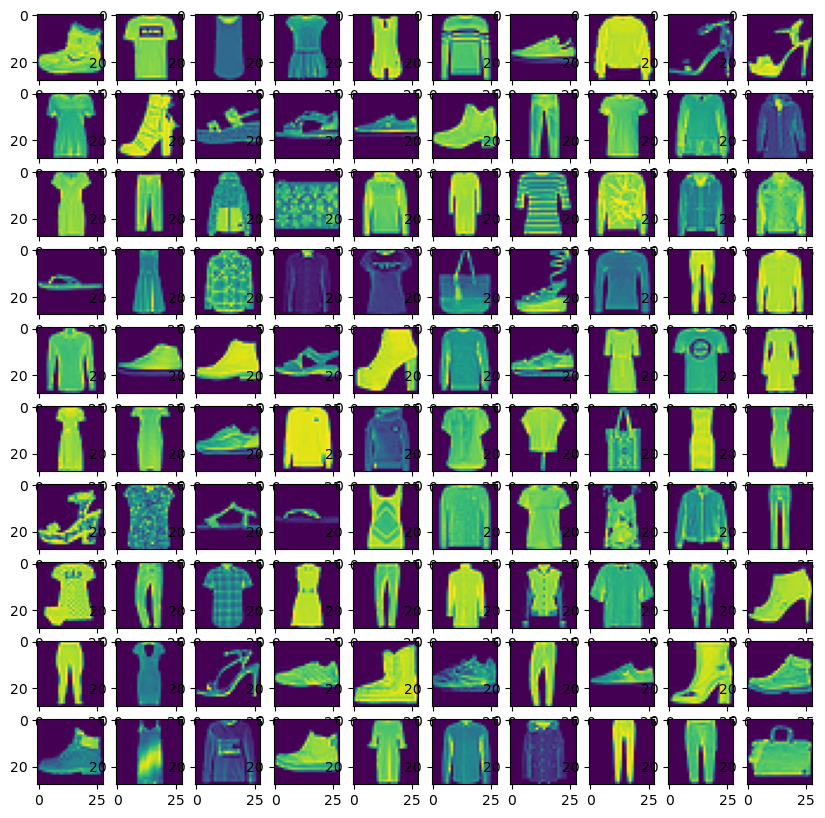

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
fig = plt.figure(figsize=[10, 10])
for i in range(100):
    ax = fig.add_subplot(10, 10, i + 1)
    ax.imshow(x_train[i,:])
    
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1) / 255
y_train = y_train.reshape(y_train.shape[0], 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1) / 255
y_test = y_test.reshape(y_test.shape[0], 1)    

## Our Network: A Simple Deep Convoluational Neural Network

We'll use our first DCNN from the classification example. In this case, we're most interested in playing with training parameters, so we'll use this network and play with the training parameters.

In [3]:
def get_model():
    inputs = keras.Input(shape=(28, 28, 1, ), name='img')
    x = layers.Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(inputs)
    x = layers.MaxPool2D(pool_size=(2, 2))(x)
    x = layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(x)
    x = layers.MaxPool2D(pool_size=(2, 2))(x)
    x = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(10, activation='softmax')(x)

    model_cnn = keras.Model(inputs=inputs, outputs=outputs, name='fashion_mnist_cnn_model')
    
    return model_cnn

We'll start with pretty much what we had in the example. The only difference is I've reduced the number of epochs.

In [4]:
model_cnn = get_model()
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  optimizer=keras.optimizers.RMSprop(),
                  metrics=['accuracy'], jit_compile=False)
history = model_cnn.fit(x_train, y_train,
                        batch_size=64,
                        epochs=10,
                        validation_split=0.2, verbose=False)

I0000 00:00:1738040198.983820  526756 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1880 MB memory:  -> device: 0, name: NVIDIA A16-4Q, pci bus id: 0000:02:0b.0, compute capability: 8.6
I0000 00:00:1738040200.083212  526794 cuda_dnn.cc:529] Loaded cuDNN version 90300


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


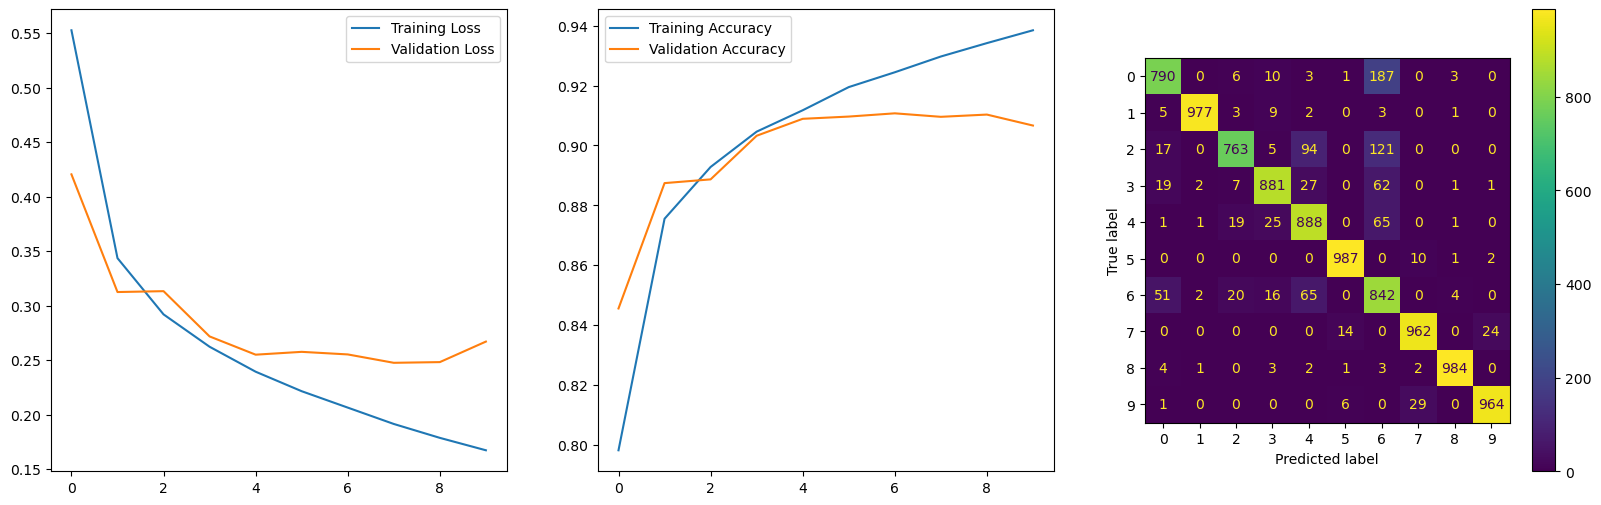

In [5]:
def plot_training(history, model, x_test, y_test):
    fig = plt.figure(figsize=[20, 6])
    ax = fig.add_subplot(1, 3, 1)
    ax.plot(history.history['loss'], label="Training Loss")
    ax.plot(history.history['val_loss'], label="Validation Loss")
    ax.legend()

    ax = fig.add_subplot(1, 3, 2)
    ax.plot(history.history['accuracy'], label="Training Accuracy")
    ax.plot(history.history['val_accuracy'], label="Validation Accuracy")
    ax.legend();
    
    pred = model.predict(x_test);
    indexes = keras.ops.argmax(pred, axis=1)
    
    cm = confusion_matrix(y_test, indexes)
    ax = fig.add_subplot(1, 3, 3)
    c = ConfusionMatrixDisplay(cm, display_labels=range(10))
    c.plot(ax = ax)
    
plot_training(history, model_cnn, x_test, y_test)

## Optimisers

One of our big choices is the optimiser we use. We have lots of options in tensorflow/keras. We'll consider:
* Stochastic Gradient Descent (sgd): the original, will follow the gradient downhill. Can optionally use mometum to smooth the updates and avoid osciliations, such that the update at the current timestep is a result of the current gradient and some amount of the previous
* RMSProp: SGDM has one learning rate for everything, RMSProp allows the learning rate to vary per parameter. Parameters with a very steep gradient have a slower learning rate (as they'll change fast anyway), and those with a shallow gradient have a higher learning rate (to try shift them). This is what we used above
* Adam: or Adaptive Moment Estimation. Can essentially be seen as RMSProp with momentum.

Each of these have parameters you can tune as well, but the default values work well for the majority of problems, and you won't get huge gains by tuning things either, so we'll leave them as is. More information on the keras API is available [here](https://keras.io/api/optimizers/), and if you're interested in a heap of benchmarks on optimisers (that does a fair job of showing how similar they really are) [this](https://arxiv.org/abs/2007.01547) is an excellent read.

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step


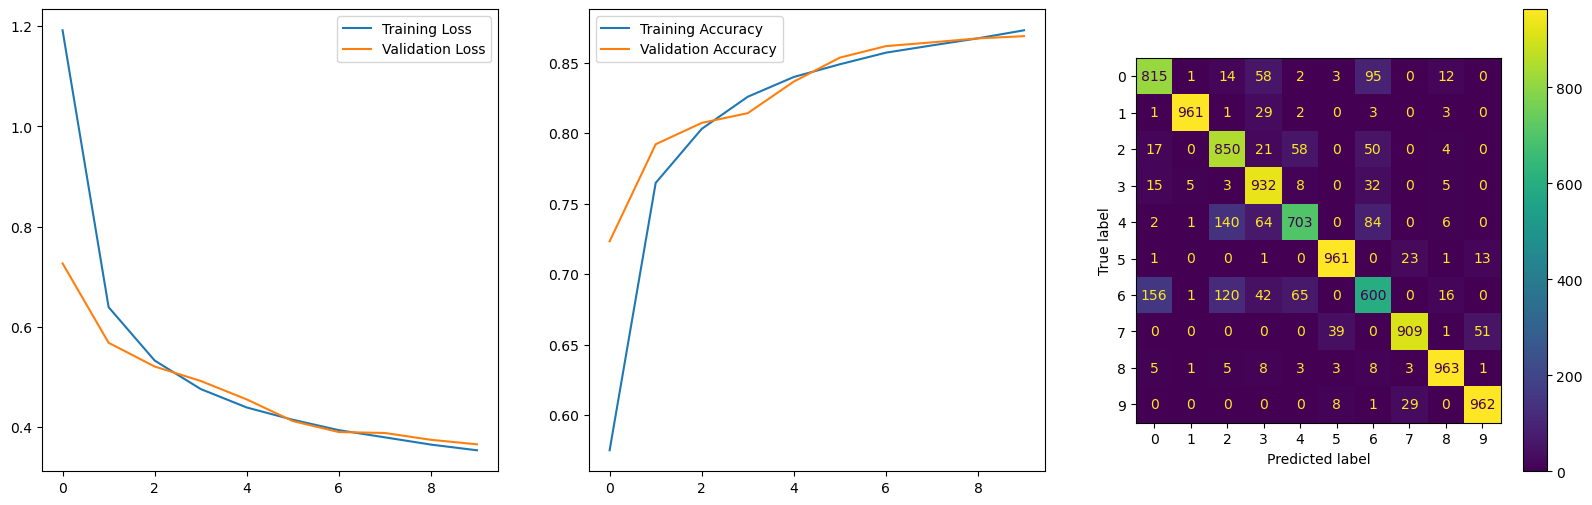

In [6]:
model_cnn = get_model()
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  optimizer=keras.optimizers.SGD(),
                  metrics=['accuracy'], jit_compile=False)
history = model_cnn.fit(x_train, y_train,
                        batch_size=64,
                        epochs=10,
                        validation_split=0.2, verbose=False)
plot_training(history, model_cnn, x_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step


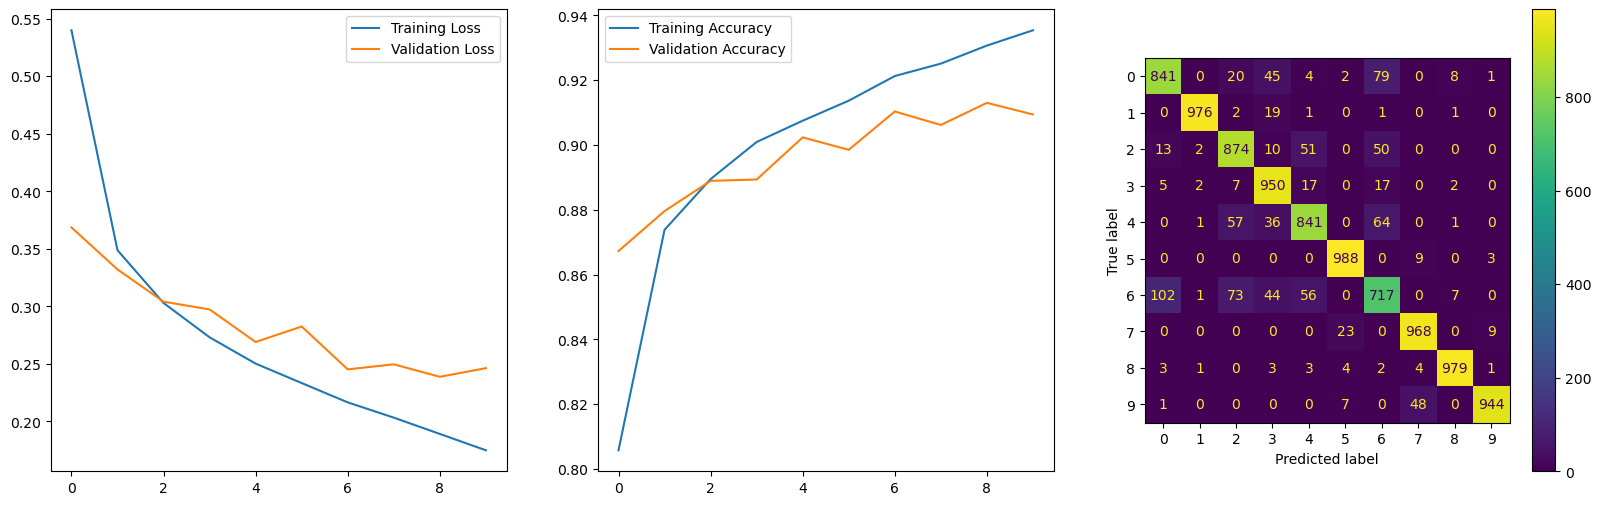

In [7]:
model_cnn = get_model()
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'], jit_compile=False)
history = model_cnn.fit(x_train, y_train,
                        batch_size=64,
                        epochs=10,
                        validation_split=0.2, verbose=False)
plot_training(history, model_cnn, x_test, y_test)

From the above, we see no big difference. Generally RMSProp and Adam will learn a bit quicker, and Adam is generaly a bit more stable than RMSProp due to momentum. For this subject, all of these will be fine, but Adam is often the better choice owing to the ability to vary the learning rate per parameter while still having momentum.

In most cases in this subject, you'll see more variation in training runs due to random initialisation than due to choice of optimiser.

## Learning Rate

The learning rate controls how fast things are updated. A very fast learning rate will change quickly, but the network can "overshoot" the optimum result. Too slow a learning rate and you'll be waiting forever. We also can have a learning rate schedule such that the learning rate decays over time, or by default the learning rate will drop every 10 epochs. Again, the defaults are good in this case, but it doesn't hurt to have a look at learning rate and what can happen.

For this evaluation, we'll use SGD as our base optimiser.

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step


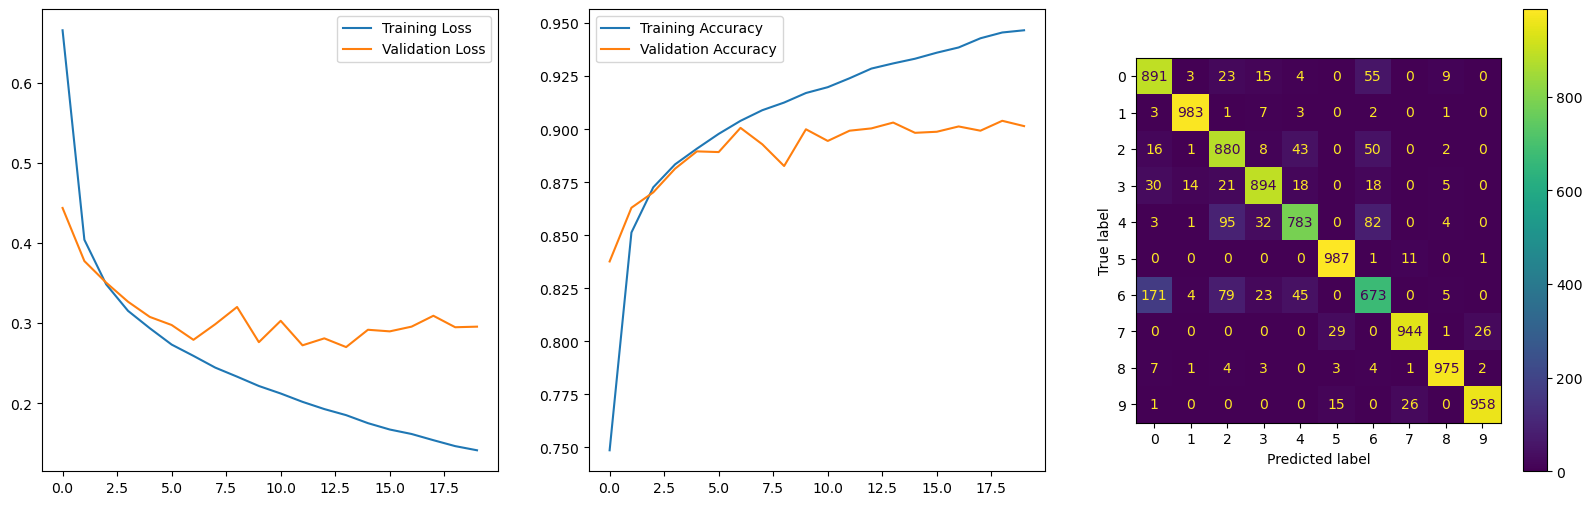

In [8]:
model_cnn = get_model()
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  optimizer=keras.optimizers.SGD(learning_rate=0.1),
                  metrics=['accuracy'], jit_compile=False)
history = model_cnn.fit(x_train, y_train,
                        batch_size=64,
                        epochs=20,
                        validation_split=0.2, verbose=False)
plot_training(history, model_cnn, x_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


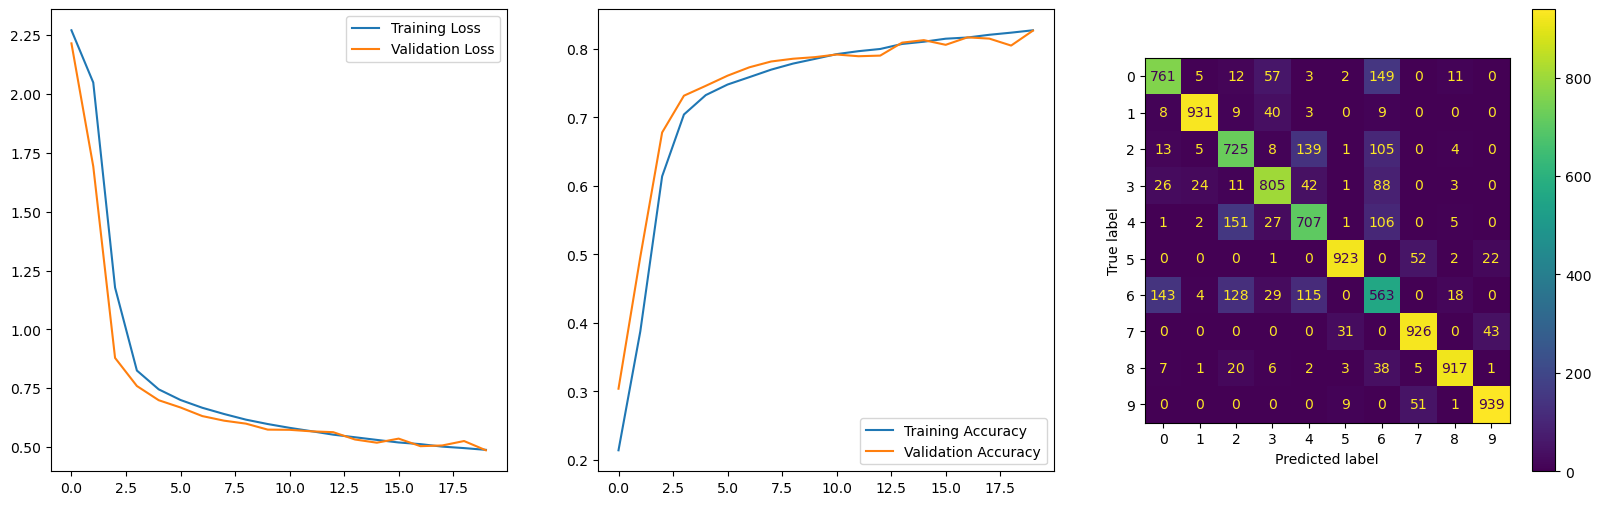

In [9]:
model_cnn = get_model()
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  optimizer=keras.optimizers.SGD(learning_rate=0.001),
                  metrics=['accuracy'], jit_compile=False)
history = model_cnn.fit(x_train, y_train,
                        batch_size=64,
                        epochs=20,
                        validation_split=0.2, verbose=False)
plot_training(history, model_cnn, x_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step


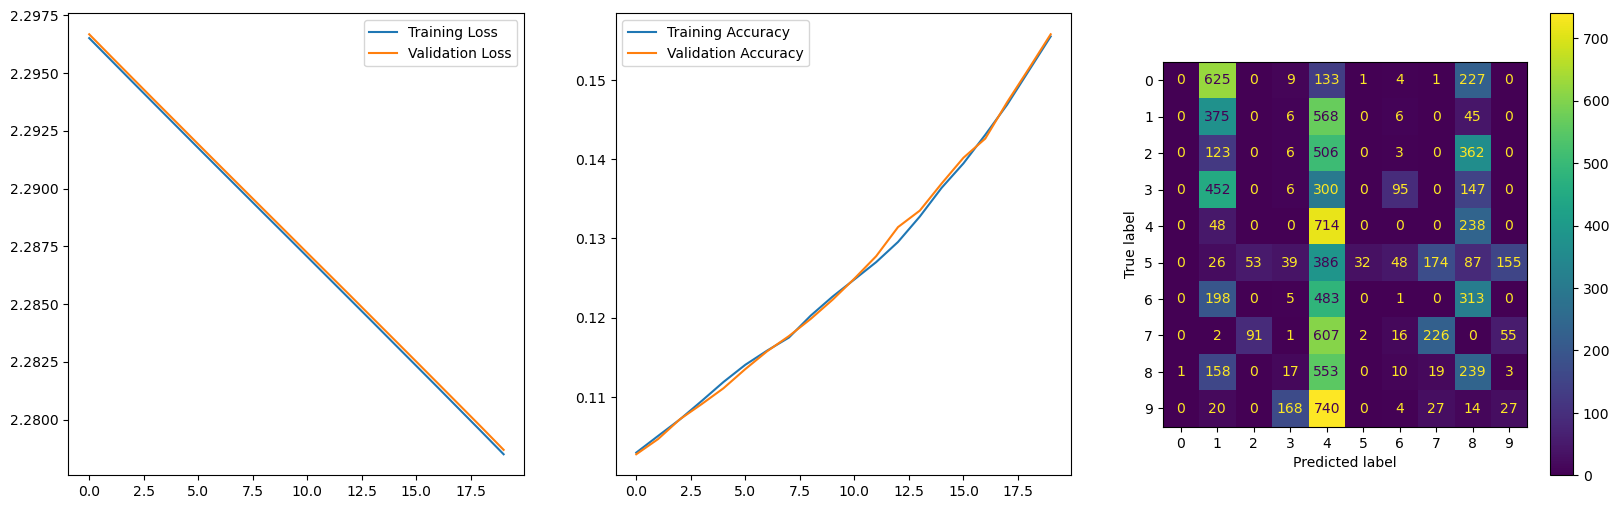

In [10]:
model_cnn = get_model()
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  optimizer=keras.optimizers.SGD(learning_rate=0.00001),
                  metrics=['accuracy'], jit_compile=False)
history = model_cnn.fit(x_train, y_train,
                        batch_size=64,
                        epochs=20,
                        validation_split=0.2, verbose=False)
plot_training(history, model_cnn, x_test, y_test)

What we see is not terribly surprsing:
* With a fast learning rate, the model reaches it's peak quicker, but the plot is rougher, with more variation (training is less stable)
* Slower learning rates result in smoother plots and more gradual improvement (leaning is more stable), but this improvement can be too gradual in the case of our final learning rate.

## Batch Size
Let's try differnet batch sizes now. We'll try
* 4
* 16
* 256
* 1024

We have been using 64 already, so we can skip that one. At a batch size of 4, we'll do 16x more gradient descent updates per epoch than with a batch size of 64. If we have limited data, this is one way to give our model an extra chance to learn. The danger is that with a batch size of 4, there is no way that in one batch our model can see all classes (we have 10). Bigger batch sizes mean the statistics of the batch look more like the overall statistics of the data (which is good), but bigger batches:
* need more memory, which for large networks becomes a real issue
* mean fewer passes through gradient descent for the same number of epochs (fewer model updates, though we can overcome this easily by training for more epochs)

We'll swap back to using Adam as our optimiser with default parameters.

In [ ]:
model_cnn = get_model()
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'], jit_compile=False)
history = model_cnn.fit(x_train, y_train,
                        batch_size=4,
                        epochs=10,
                        validation_split=0.2, verbose=False)
plot_training(history, model_cnn, x_test, y_test)

In [ ]:
model_cnn = get_model()
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'], jit_compile=False)
history = model_cnn.fit(x_train, y_train,
                        batch_size=16,
                        epochs=10,
                        validation_split=0.2, verbose=False)
plot_training(history, model_cnn, x_test, y_test)

In [ ]:
model_cnn = get_model()
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'], jit_compile=False)
history = model_cnn.fit(x_train, y_train,
                        batch_size=256,
                        epochs=10,
                        validation_split=0.2, verbose=False)
plot_training(history, model_cnn, x_test, y_test)

In [ ]:
model_cnn = get_model()
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'], jit_compile=False)
history = model_cnn.fit(x_train, y_train,
                        batch_size=1024,
                        epochs=10,
                        validation_split=0.2, verbose=False)
plot_training(history, model_cnn, x_test, y_test)

For our larger batch size we see a very smooth training curve, but performance is actually slightly lower, our model most likely hasn't converged yet. While it's seen the same amount of data, it's made less model updates. This version has also trained much faster (fewer model updates), but for larger tasks such a large batch size wouldn't be possible due to memory limitations. 

Batch size is usually limited by network size and the amount of memory you have on your system. In this case, we have a small network with small format data, so we can get away with a large batch size.

## Final Thoughts

We have a lot of levers that we can pull with respect to our model training, but the three main ones are:
* Optimiser choice
* Batch size
* Number of epochs

The first of these is unlikely to dramatically change performance. While in some cases some optimisers will perform much more poorly than others (typically when dealing with complex networks and limited data volumes), for the vast majority of situations in CAB420 optimiser choice won't make a huge difference. At present it's hard to categorically say that there is one best optimiser (see [here](https://arxiv.org/abs/2007.01547)), but in general Adam is a good choice and the default parameters work well. 

Our other two levers directly relate to how long a model is trained for. More epochs mean more model updates, which is generally a good thing, upto the point that you overfit. Similarly, a larger batch size is generally better, up to a point. Ideally, your batch should be big enough to present a reasonable approximation of the overall data distribution. These are parameters that will vary somewhat with the data itself and the network. Bigger, more complex networks will benefit from being trained for longer. Likewise, datasets which contain more variation will likely need to train for longer to learn that variation.

With respect to selecting these parameters, visualing training curves and performance on the validation set is your friend. Also consider using callbacks such as [early stopping](https://keras.io/api/callbacks/early_stopping/) or [model checkpoint](https://keras.io/api/callbacks/model_checkpoint/) to help stop training before overfitting happens, and/or get the overall best model on the validation set.